In [1]:
# uncomment this script if you use google colab
# %cd /content/
# !rm -rf /content/Busway-Traffic-Violation-Detection
# !git clone https://github.com/ariqbasyar/Busway-Traffic-Violation-Detection.git\
#   && cd /content/Busway-Traffic-Violation-Detection/
# %cd /content/Busway-Traffic-Violation-Detection/model/busway-lane-detection-yolo/
# !ls

In [2]:
import sys
import os
import torch
import numpy as np
import cv2

from model import (preprocess, detect, box_label,
    get_busway_box_from_prediction)
from time import time
from pathlib import Path
from models.experimental import attempt_load
from shapely.geometry import MultiPoint

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
ROOT = Path('.')
WEIGHT = ROOT / 'weights'

In [4]:
weight = WEIGHT / 'yolov5m-lane-400epochs.pt'

In [5]:
random_state = np.random.RandomState(42)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')
model = attempt_load(weight, map_location=device)

using cuda


Fusing layers... 
Model Summary: 308 layers, 21049761 parameters, 0 gradients


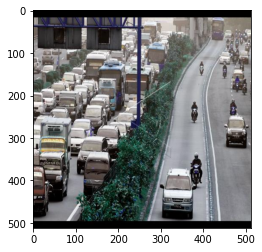

In [7]:
idx = '%03d.jpg' % random_state.randint(0,62)
main_img = cv2.imread(str(ROOT / f'dataset/preprocessed_512x512/{idx}'))
plt.imshow(main_img)
plt.show()

# Preprocess

In [8]:
preprocessed = preprocess(main_img,device)

# Detect

In [9]:
start = time()
pred = detect(model,preprocessed)
print(f'inferenced in {(time() - start)*1E3:.2f}ms')

inferenced in 143.35ms


# Plot

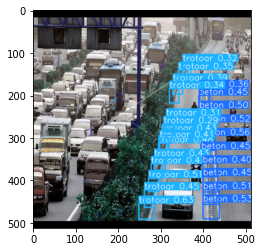

In [10]:
labeled_img = box_label(pred,main_img.copy())
plt.imshow(labeled_img)
plt.show()

# Extract by labels

amount of convex hull points: 9


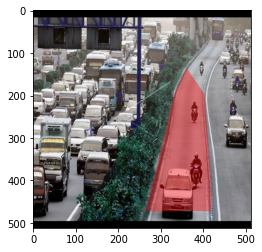

In [11]:
lane_box = get_busway_box_from_prediction(pred)
if lane_box is None:
  print("Cant make polygon from the prediction")
else:
  x,y = lane_box.exterior.xy

  points = np.int32([x,y])
  points = points.transpose()
  print(f'amount of convex hull points: {len(points)}')

  _img = main_img.copy()
  cv2.fillPoly(_img, [points], (255,0,0))
  alpha = 0.4
  image_new = cv2.addWeighted(_img, alpha, main_img, 1 - alpha, 0)
  plt.imshow(image_new)
  plt.show()